# Разработка модели предсказания болезней сердца

Целью настоящего проекта провести анализ представленных данных, о пациентах, у которых есть или нет сердечных заболеваний и на основании информации по кажлдому конкретному пациенту разработать модель машинного обучения для возможности предсказывать наличие болезней сердца по аналогичным данным.

Работать будем с датасетом из 16 признаков:
* `id` - уникальный номер пациента;
* `age` - возраст пациента;
* `sex` - пол пациента;
* `datasets` - место сбора данных;
* `cp` - тип боли в груди;
 * `typical angina` - типичная стенокардия;
 * `atypical angina` - атипичная стенокардия;
 * `non-anginal` - не является стенокардией;
 * `asymptomatic` - безсимптномный;
* `trestbps` - кровяное давление в состоянии покоя, мм рт. ст.;
* `chol` - количиство холестирина, мг/дл;
* `fbs` - уровень сахара в крови:
 * True, если уровень > 120 мг/дл;
 * False иначе;
* `restecg` - результаты электрокардиограммы в состоянии покоя:
 * `normal` - в норме;
 * `stt abnormality` - есть аномалия;
 * `lv hypertrophy` - гпертрофия левого желудочка;
* `thalch` - максимальная частота сердечных сокращений;
* `exang` - стенокардия, вызванная физической нагрузкой (True/False);
* `oldpeak`- Уменьшение ST, вызванное физической нагрузкой, по сравнению с состоянием покоя;
* `slope` - наклон пикового сегмента ST при нагрузке;
* `ca` - количество крупных сосудов (0-3), окрашенных при рентгеноскопии;
* `thal` - талласемия:
 * `normal` - в норме;
 * `fixed defect` - фиксированный дефект;
 * `fixed defect` - обратимый дефект;
* `num` - целевой признак:
 * `0` - сердечная болезнь отсутствует;
 * `1, 2, 3, 4` - стадии сердечной болезни.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [2]:
try:
    data = pd.read_csv('C://Users//User//Desktop//Яндекс Практикум//DataScience//12. Мастерская_1//heart_disease_uci.csv')
except:
    data = pd.read_csv('C://Users//asus//Desktop//Яндекс Практикум//DataScience//14 Мастерская_1//heart_disease_uci.csv')

## 1. Исследовательский анализ данных

Изучим данные:

In [3]:
data.head()

id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


Колонкa `id` нам не нужна - она не несет в себе никакой полезной информации. Удалим ее:

In [5]:
data = data.drop('id', axis = 1)

Распределение количественных признаков:

In [6]:
data.describe()

age    trestbps        chol      thalch     oldpeak          ca  \
count  920.000000  861.000000  890.000000  865.000000  858.000000  309.000000   
mean    53.510870  132.132404  199.130337  137.545665    0.878788    0.676375   
std      9.424685   19.066070  110.780810   25.926276    1.091226    0.935653   
min     28.000000    0.000000    0.000000   60.000000   -2.600000    0.000000   
25%     47.000000  120.000000  175.000000  120.000000    0.000000    0.000000   
50%     54.000000  130.000000  223.000000  140.000000    0.500000    0.000000   
75%     60.000000  140.000000  268.000000  157.000000    1.500000    1.000000   
max     77.000000  200.000000  603.000000  202.000000    6.200000    3.000000   

              num  
count  920.000000  
mean     0.995652  
std      1.142693  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      2.000000  
max      4.000000

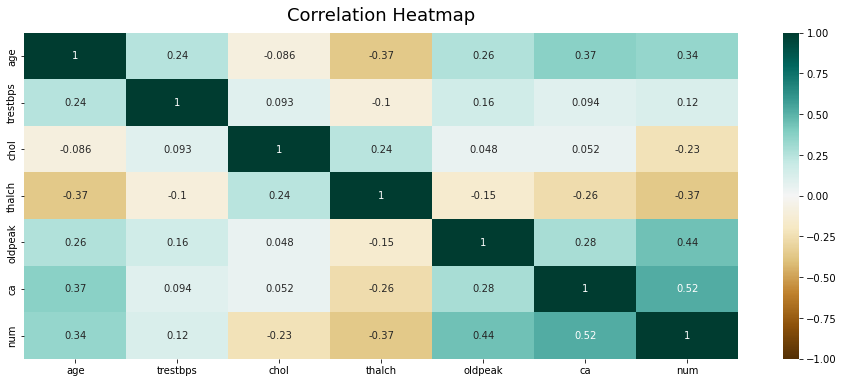

In [7]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12); 


Посмотрим зависимости припомощи диаграмм рассеивания:

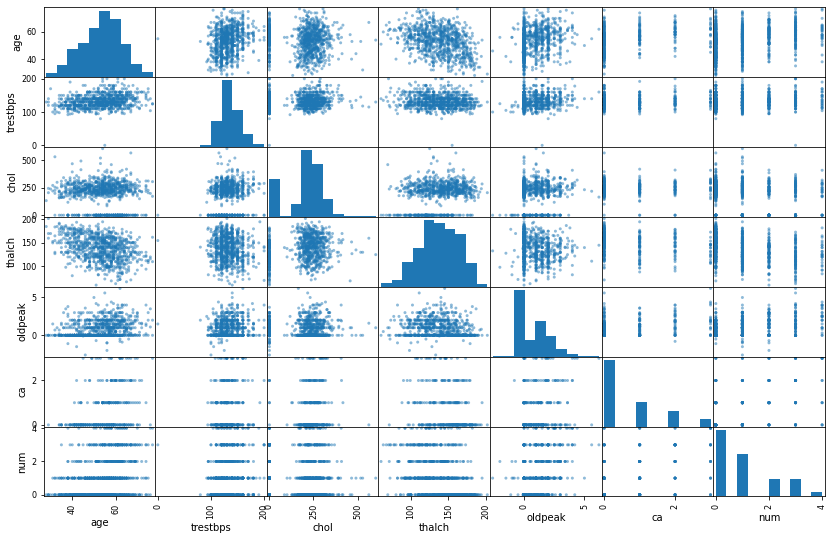

In [8]:
pd.plotting.scatter_matrix(data, figsize=(14, 9));

Прямых зависимостей не выявлено

Изучим распределение категориальных признаков:

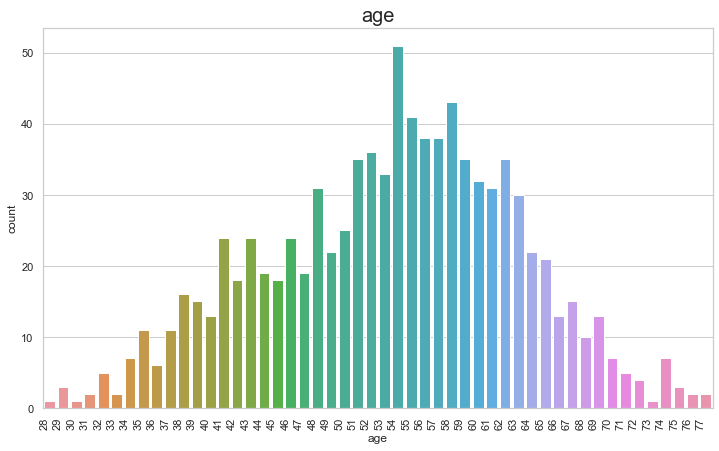

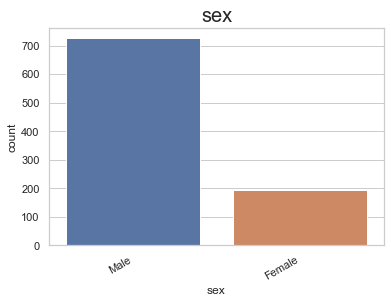

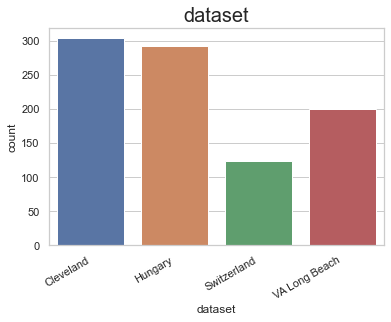

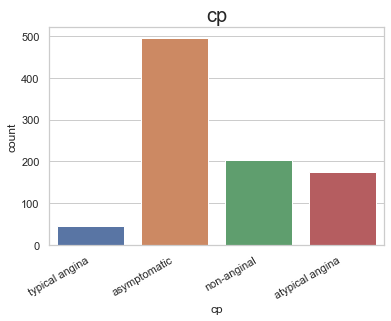

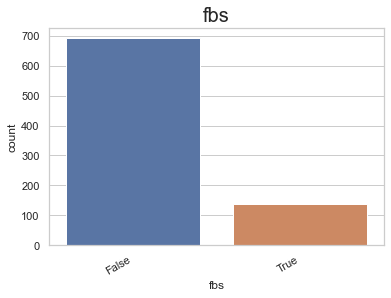

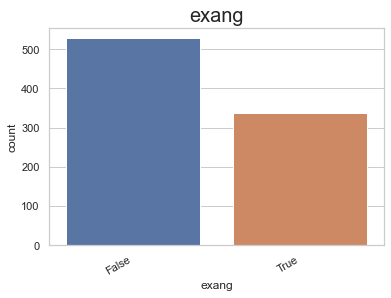

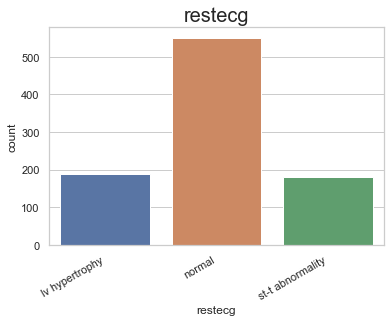

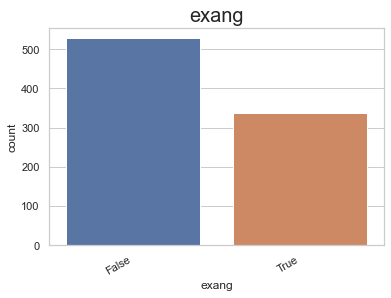

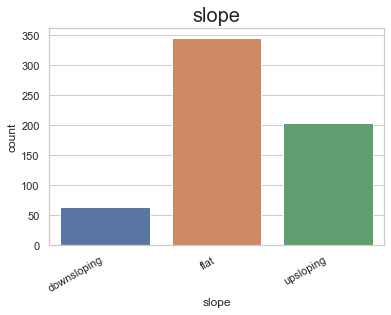

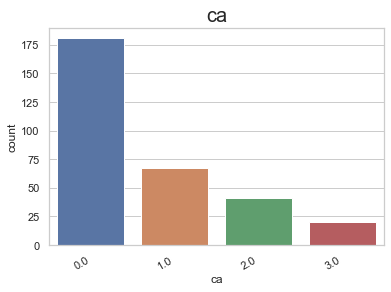

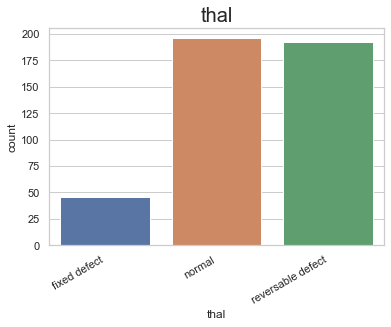

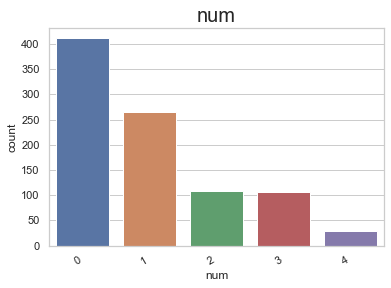

In [9]:
for column in data[['age', 'sex', 'dataset', 'cp', 'fbs', 'exang',
                   'restecg', 'exang', 'slope', 'ca', 'thal', 'num']]:
    if column == 'age':
        sns.set_theme(style='whitegrid')
        plt.figure(figsize=(12,7))
        ax = sns.countplot(x=data[column])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
        plt.title(column, fontsize=20)
        plt.show()
    else:
        sns.set_theme(style='whitegrid')
        ax = sns.countplot(x=data[column])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
        plt.title(column, fontsize=20)
        plt.show()

Изучим количественные признаки:

Зависимсоть уровня холестирина, максимальной частоты сердечных сокращений и артериального давления от возраста. Так же посмотрим как распределяются стадии болезни сердца.

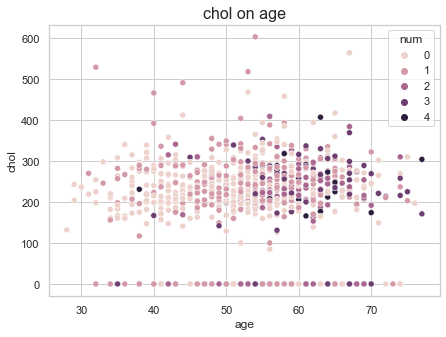

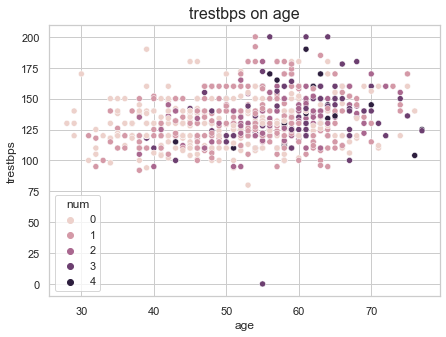

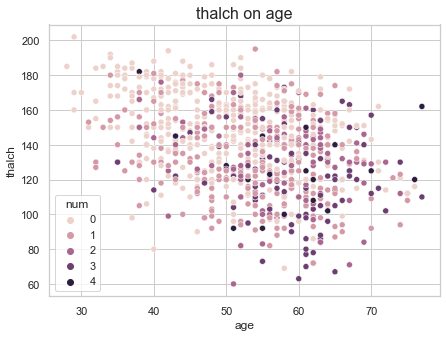

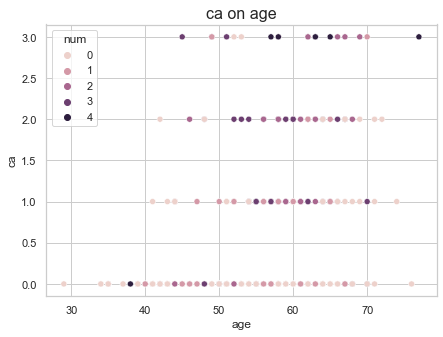

In [10]:
for column in ['chol', 'trestbps', 'thalch', 'ca']:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data = data, x='age', y=column, hue = 'num');
    plt.title(f'{column} on age', fontsize=16)
    plt.show()



Так же посмотрим распределение данных на диаграмме размаха:

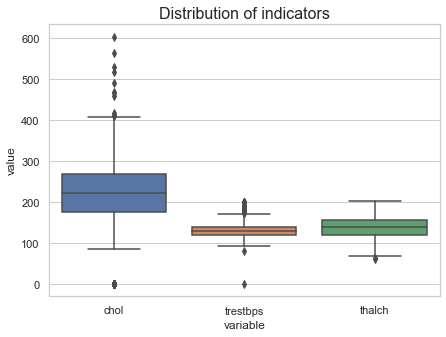

In [11]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='variable', y='value', data=pd.melt(data[['chol', 'trestbps', 'thalch']]));
plt.title('Distribution of indicators', fontsize=16);

Гистограммы количественных признаков:

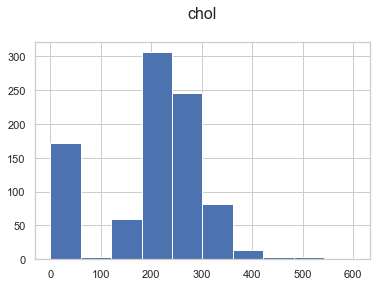

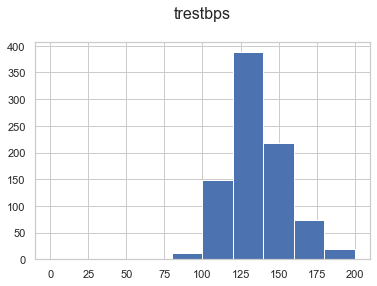

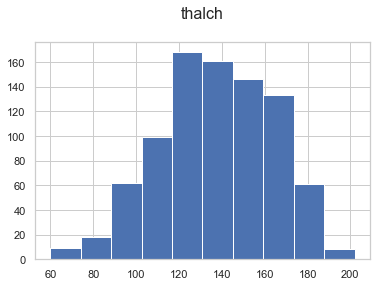

In [12]:
for column in data[['chol', 'trestbps', 'thalch']]:
    data[column].hist()
    plt.title(column + '\n', fontsize=16)
    plt.show()

Зависимость стадий заболевания от средних показателей:

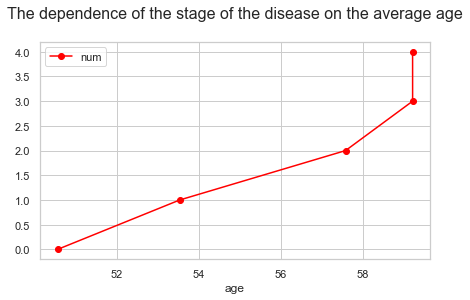

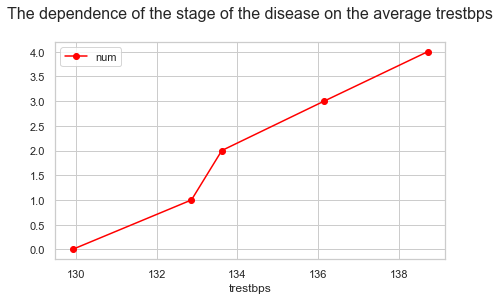

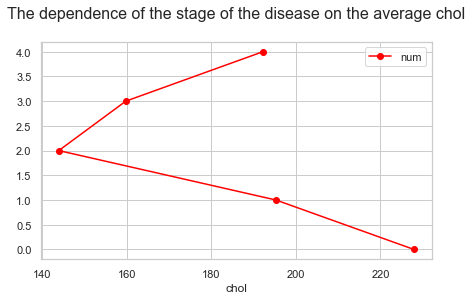

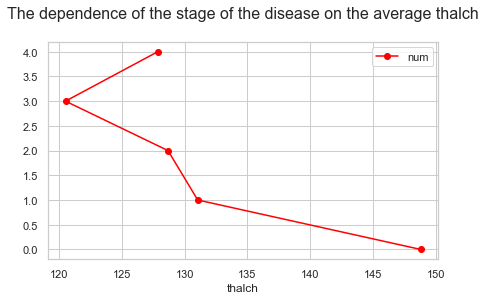

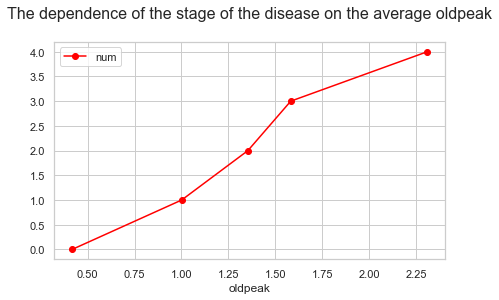

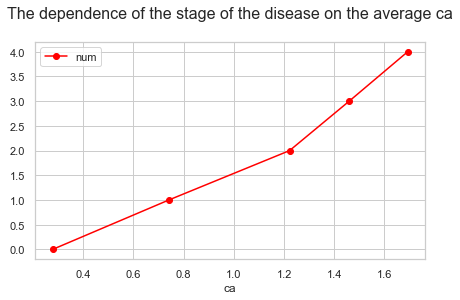

In [13]:
for column in data.groupby('num').mean().columns:     
    data.pivot_table(
        index='num', values=column, aggfunc='mean'
    ).reset_index().plot(x=column, y='num', kind='line', figsize=(7,4),  style = 'o-', color='red')
    plt.title(f'The dependence of the stage of the disease on the average {column}' + '\n', fontsize=16);

### Вывод:

В результате проведенного анализа выяснили:
* Есть пропущенные значени признаков, которые можно заменить на среднее или медиану. Метод describe показал;
* Есть значения уровня холестирина и артериального давления равные нулю, что так же необходимо поправить;
* Данные колонок с уникальным номером, а так же с местом сбора данных не информативны для построения модели - их можно удалить;
* Выявлены зависимости стадийности заболевания от таких параметров как:
    * возраст;
    * артериальное давление;
    * максимальная частота сердечных сокращений;
    * уменьшение ST, вызванное физической нагрузкой, по сравнению с состоянием покоя;
    * количество крупных сосудов при рентгеноскопии.

## 2. Предобработка данных

### 2.1 Подготовка данных

Удалим информацию с местом сбора данных:

In [14]:
data.drop('dataset', axis=1, inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 100.8+ KB


Заменим пропуски. Для категориальных признаков на наиболее часто встречающееся значение. Для количественных признаков - на медиану.

In [16]:
data.describe()

age    trestbps        chol      thalch     oldpeak          ca  \
count  920.000000  861.000000  890.000000  865.000000  858.000000  309.000000   
mean    53.510870  132.132404  199.130337  137.545665    0.878788    0.676375   
std      9.424685   19.066070  110.780810   25.926276    1.091226    0.935653   
min     28.000000    0.000000    0.000000   60.000000   -2.600000    0.000000   
25%     47.000000  120.000000  175.000000  120.000000    0.000000    0.000000   
50%     54.000000  130.000000  223.000000  140.000000    0.500000    0.000000   
75%     60.000000  140.000000  268.000000  157.000000    1.500000    1.000000   
max     77.000000  200.000000  603.000000  202.000000    6.200000    3.000000   

              num  
count  920.000000  
mean     0.995652  
std      1.142693  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      2.000000  
max      4.000000

In [17]:
quantitative = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical = ['fbs', 'restecg', 'exang', 'slope', 'thal']

Создадим дополнительный столбец с категорией возраста:
* молодой - до 44 лет,
* средний возраст - до 59, 
* пожилой - выше 59.

In [18]:
data['category_age'] = data['age'].apply(lambda x: 'young' if x <= 44 else 'middle' if x <= 59 else 'old')
data.head()


age     sex               cp  trestbps   chol    fbs         restecg  \
0   63    Male   typical angina     145.0  233.0   True  lv hypertrophy   
1   67    Male     asymptomatic     160.0  286.0  False  lv hypertrophy   
2   67    Male     asymptomatic     120.0  229.0  False  lv hypertrophy   
3   37    Male      non-anginal     130.0  250.0  False          normal   
4   41  Female  atypical angina     130.0  204.0  False  lv hypertrophy   

   thalch  exang  oldpeak        slope   ca               thal  num  \
0   150.0  False      2.3  downsloping  0.0       fixed defect    0   
1   108.0   True      1.5         flat  3.0             normal    2   
2   129.0   True      2.6         flat  2.0  reversable defect    1   
3   187.0  False      3.5  downsloping  0.0             normal    0   
4   172.0  False      1.4    upsloping  0.0             normal    0   

  category_age  
0          old  
1          old  
2          old  
3        young  
4        young

Заменим пропуски в количественных признаках на медианы возрастных групп:

In [19]:
data_clean =data.copy()
# замена на медианы. Медианы рассчитаны без учета нулевых значений
for i in quantitative:
    data_clean[i] = data.loc[data[i] != 0].groupby(
        'category_age')[i].transform(lambda x: x.fillna(x.median())
                                    )
# получили пропуски там, где нулевые значения
for i in ['trestbps', 'chol']:
    data_clean[i] = data_clean.groupby(
        'category_age')[i].transform(lambda x: x.fillna(x.median())
                                    )
    
# еще одна замена пропусков в тех признаках, где 0 значение нормальное
data_clean['oldpeak'].fillna(0, inplace=True)
data_clean['ca'].fillna(0, inplace=True)

От признаков slope, thal, ca избавляемся, так как в них пропущено более 50 процентов информации.

In [20]:
data_clean.drop(['slope', 'thal'], axis=1, inplace=True)

В оставшихся категориальных признаках пропуски заменим на значение, которого болшьше всего в категории: 

In [21]:
for i in ['fbs', 'restecg', 'exang']:
    data_clean[i] = data_clean[i].fillna(data_clean[i].value_counts().index[0])

In [22]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           920 non-null    int64  
 1   sex           920 non-null    object 
 2   cp            920 non-null    object 
 3   trestbps      920 non-null    float64
 4   chol          920 non-null    float64
 5   fbs           920 non-null    bool   
 6   restecg       920 non-null    object 
 7   thalch        920 non-null    float64
 8   exang         920 non-null    bool   
 9   oldpeak       920 non-null    float64
 10  ca            920 non-null    float64
 11  num           920 non-null    int64  
 12  category_age  920 non-null    object 
dtypes: bool(2), float64(5), int64(2), object(4)
memory usage: 81.0+ KB


In [23]:
data_clean.drop(['category_age'], axis=1, inplace=True)

Проверка на дубликаты:

In [24]:
data_clean.duplicated().sum()

2

Удаление дублей:

In [25]:
data_clean.drop_duplicates(inplace=True)

В данной задаче необходимо предсказать есть ли у пациента сердечное заболевание или нет. В целевом признаке имеем 5 классов 0 - не болен и 1,2,3,4 - стадии заболевания. Важно определить есть ли заболевание, а стадию определит дальнейшее обследование. Поэтому заменим классы 1,2,3,4 на 1:

In [26]:
# функция, применимая к целевому столбцу
def replacement (value):
    if value != 0:
        return 1
    else:
        return value

In [27]:
data_clean['num'] = data_clean['num'].apply(replacement)

In [28]:
data_clean['fbs'] = data_clean['fbs'].apply(lambda x: 1 if x is True else 0)
data_clean['exang'] = data_clean['fbs'].apply(lambda x: 1 if x is True else 0)

Некоторые признаки имеют тип данных object - для моделей классификации они не понятны поэтому приведем классы в 0 и 1 техникой OneHotEncoder:

In [29]:
data_processed = pd.get_dummies(data_clean, drop_first=True)

In [30]:
data_processed.shape

(918, 15)

In [31]:
data_processed

age  trestbps   chol  fbs  thalch  exang  oldpeak   ca  num  sex_Male  \
0     63     145.0  233.0    1   150.0      0      2.3  0.0    0         1   
1     67     160.0  286.0    0   108.0      0      1.5  3.0    1         1   
2     67     120.0  229.0    0   129.0      0      2.6  2.0    1         1   
3     37     130.0  250.0    0   187.0      0      3.5  0.0    0         1   
4     41     130.0  204.0    0   172.0      0      1.4  0.0    0         0   
..   ...       ...    ...  ...     ...    ...      ...  ...  ...       ...   
915   54     127.0  333.0    1   154.0      0      0.0  1.0    1         0   
916   62     138.0  139.0    0   130.0      0      1.5  2.0    0         1   
917   55     122.0  223.0    1   100.0      0      0.0  1.0    1         1   
918   58     130.0  385.0    1   139.0      0      1.4  1.0    0         1   
919   62     120.0  254.0    0    93.0      0      0.0  2.0    1         1   

     cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
0                     0               0                  1               0   
1                     0               0                  0               0   
2                     0               0                  0               0   
3                     0               1                  0               1   
4                     1               0                  0               0   
..                  ...             ...                ...             ...   
915                   0               0                  0               0   
916                   0               0                  1               0   
917                   0               0                  0               0   
918                   0               0                  0               0   
919                   1               0                  0               0   

     restecg_st-t abnormality  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  
..                        ...  
915                         1  
916                         1  
917                         1  
918                         0  
919                         0  

[918 rows x 15 columns]

Разделим датасет на признаки и таргет:

In [32]:
features = data_processed.drop('num', axis=1)
target = data_processed['num']

Для проверки качества модели выделим тестовую выборку в соотношении 75/25:

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify=target)

### 2.2 Стандартизация данных

Данные привели в цифрам и классам 0 и 1, но есть так же и количесвенные признаки, которые по значению выше, чем 0 и 1 и следовательно наша модель будет опреелять как более важный признак тот,у которого значение выше, что не правильно. Что бы недопустить данную ошибку стандартизируем данные относительно 0 и 1:

In [34]:
numeric = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
scaler = RobustScaler()
scaler.fit(features_train[numeric])

RobustScaler()

In [35]:
pd.options.mode.chained_assignment = None
                              
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверка баланса классов:

1    0.553779
0    0.446221
Name: num, dtype: float64


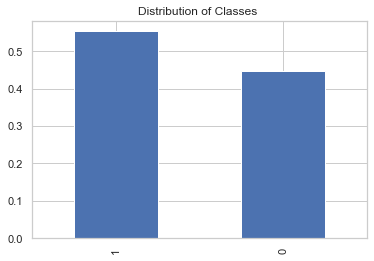

In [36]:
print(target_train.value_counts(normalize=True))
target_train.value_counts(normalize=True).plot(kind='bar', grid=True, title='Distribution of Classes ');

Классы почти сбалансированы.

## 3. Обучение моделей, выбор модели и проверка качества

### 3.1 Обучение моделей и подбор гиперпараметров

Обучим и подберем гиперпараметры для трех моделей: `Дерево решений`, `Случайный лес` и `Логистическую регрессию`. Подбор гиперпараметров будем осуществлять с помощью `GridSearchCV`. В качестве метрики используем ROC_AUC:

In [37]:
#Функция, которая принимает на вход список гиперпараметров, 
# модель, метрику и количество выборок для кросс-валидации,
# а возвращает полученные параметры в ходе перебора
def grid (model, param_grid):
    grid = GridSearchCV(
        model, param_grid, scoring='roc_auc', cv=10, n_jobs=-1
    ).fit(features_train, target_train)
    grid_results = pd.DataFrame(grid.cv_results_)
    print('Наилучшее значение ROC_AUC:')
    print(grid.best_score_)
    print('Достигается при гиперпараметрах:')
    print(grid.best_params_)
    return [grid, grid_results]


#### 3.1.1 Дерево решений

In [38]:
%%time
model_DTC_1 = DecisionTreeClassifier(random_state=42)
param_grid_DTC_1 = {'max_features': range(1,14,1),
                        'max_depth': range(1,16,1)}
grid_list_DTC_1 = grid(model_DTC_1, param_grid_DTC_1)

Наилучшее значение ROC_AUC:
0.8143476920174713
Достигается при гиперпараметрах:
{'max_depth': 5, 'max_features': 12}
Wall time: 8.02 s


График распределения метрики в зависимости от гиперпараметров:

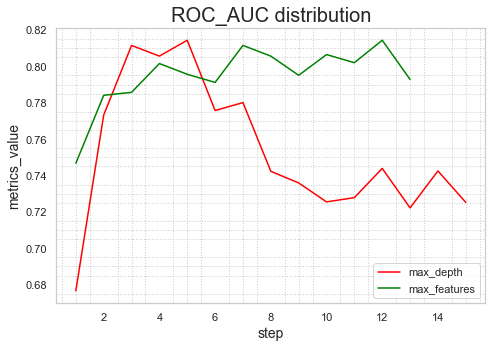

In [39]:
x_1 = grid_list_DTC_1[1].groupby('param_max_depth')['mean_test_score'].max().index
y_1 = grid_list_DTC_1[1].groupby('param_max_depth')['mean_test_score'].max()
x_2 = grid_list_DTC_1[1].groupby('param_max_features')['mean_test_score'].max().index
y_2 = grid_list_DTC_1[1].groupby('param_max_features')['mean_test_score'].max()
plt.figure(figsize=(7, 5))
plt.plot(x_1, y_1, color='red', label='max_depth')
plt.plot(x_2, y_2, color='green', label='max_features')
plt.xlabel('step', fontsize=14)
plt.ylabel('metrics_value', fontsize=14)
plt.title('ROC_AUC distribution', fontsize=20)
plt.legend()
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.show()

Запишем модель с наилучшими гиперпараметрами в переменную:

In [40]:
best_DTC_1 = DecisionTreeClassifier(
    max_depth=grid_list_DTC_1[0].best_params_['max_depth'], 
    max_features=grid_list_DTC_1[0].best_params_['max_features'],
    random_state=42
)

Проверим модель дерева решений со сбалансированными классами:

In [41]:
%%time
model_DTC_2 = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid_DTC_2 = {'max_features': range(1,14,1),
                        'max_depth': range(1,16,1)}
grid_list_DTC_2 = grid(model_DTC_2, param_grid_DTC_2)

Наилучшее значение ROC_AUC:
0.8114958716062282
Достигается при гиперпараметрах:
{'max_depth': 3, 'max_features': 7}
Wall time: 4.64 s


График:

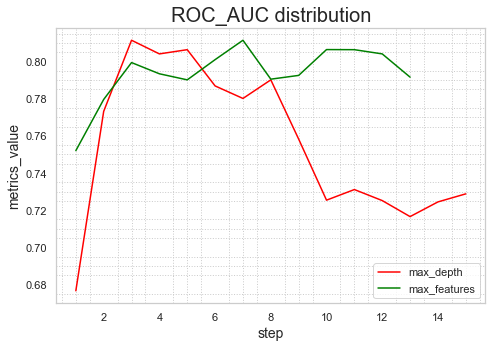

In [42]:
x_1 = grid_list_DTC_2[1].groupby('param_max_depth')['mean_test_score'].max().index
y_1 = grid_list_DTC_2[1].groupby('param_max_depth')['mean_test_score'].max()
x_2 = grid_list_DTC_2[1].groupby('param_max_features')['mean_test_score'].max().index
y_2 = grid_list_DTC_2[1].groupby('param_max_features')['mean_test_score'].max()
plt.figure(figsize=(7, 5))
plt.plot(x_1, y_1, color='red', label='max_depth')
plt.plot(x_2, y_2, color='green', label='max_features')
plt.xlabel('step', fontsize=14)
plt.ylabel('metrics_value', fontsize=14)
plt.title('ROC_AUC distribution', fontsize=20)
plt.legend()
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.show()

In [43]:
best_DTC_2 = DecisionTreeClassifier(
    max_depth=grid_list_DTC_2[0].best_params_['max_depth'], 
    max_features=grid_list_DTC_2[0].best_params_['max_features'],
    random_state=42, class_weight='balanced'
)

#### 3.1.2 Случайный лес

In [44]:
%%time
# обучим модель случайного леса и подберем гиперпараметры
model_RFC_1 = RandomForestClassifier(random_state=42)
param_grid_RFC_1 = {'n_estimators': range(1,202,10),
                    'max_depth': range(5,21,1)
                   }
grid_list_RFC_1 = grid(model_RFC_1, param_grid_RFC_1)


Наилучшее значение ROC_AUC:
0.8713961081363457
Достигается при гиперпараметрах:
{'max_depth': 6, 'n_estimators': 161}
Wall time: 3min 39s


График распределения метрики в зависимости от гиперпараметров:

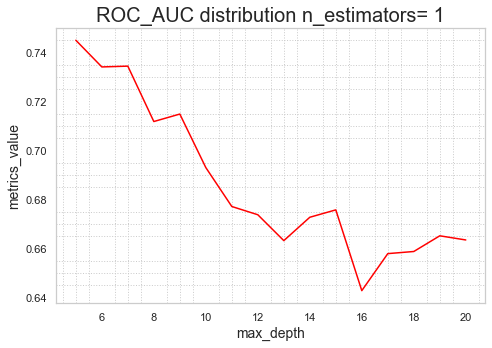

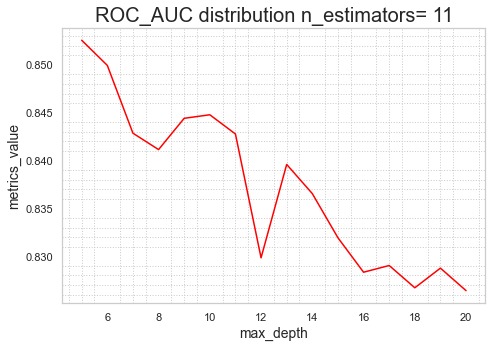

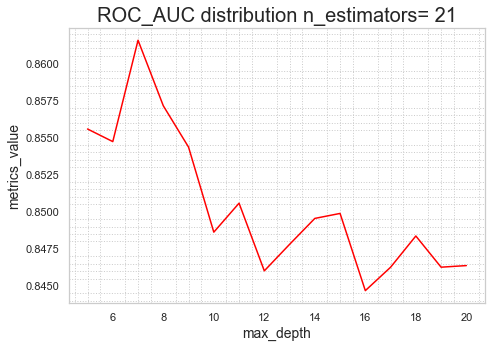

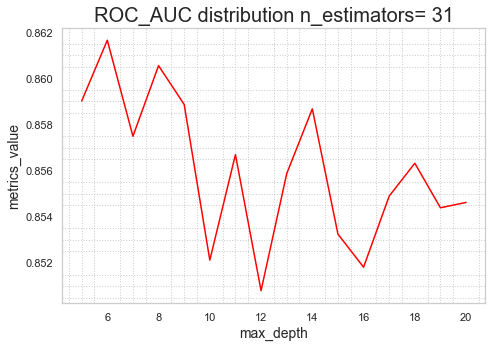

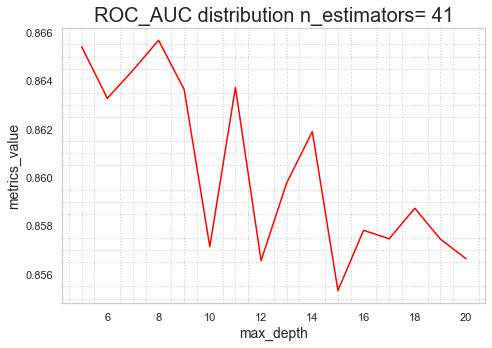

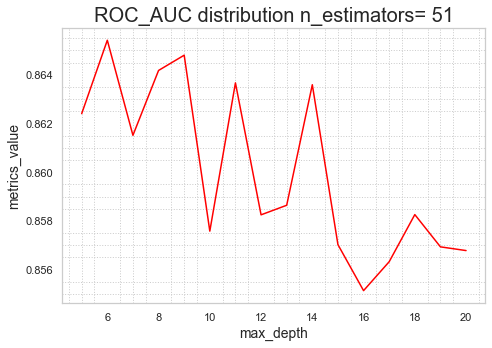

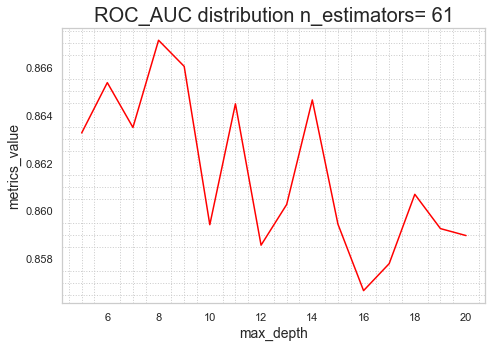

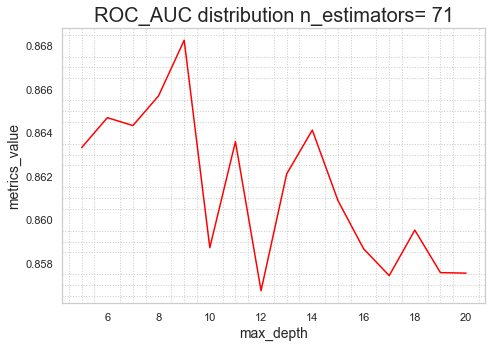

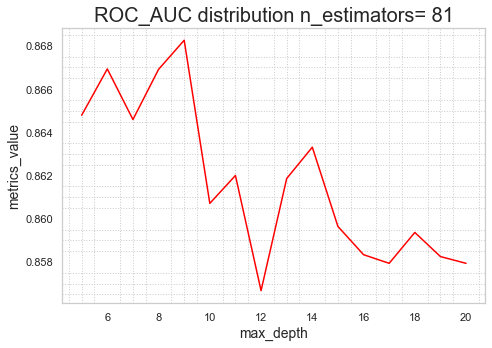

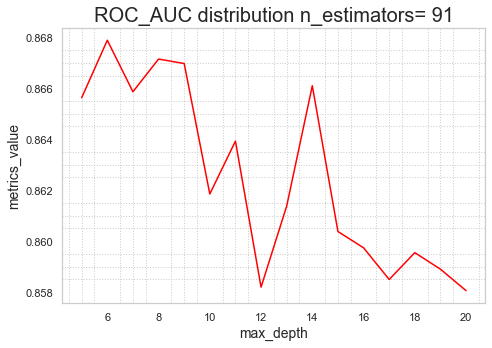

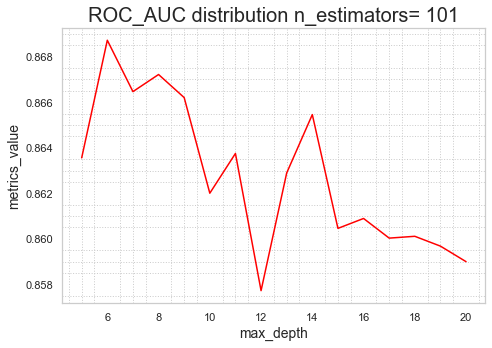

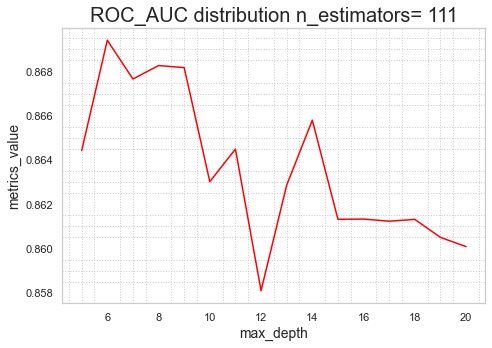

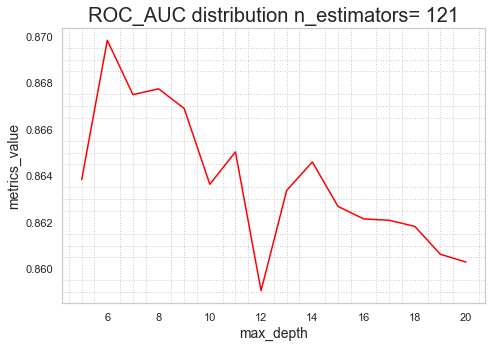

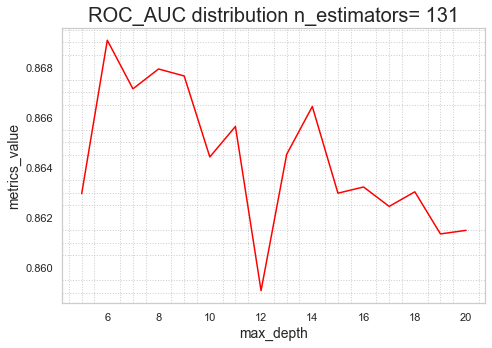

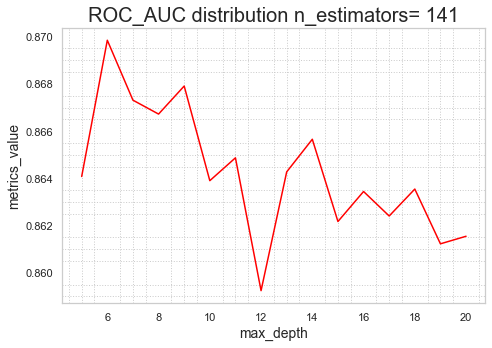

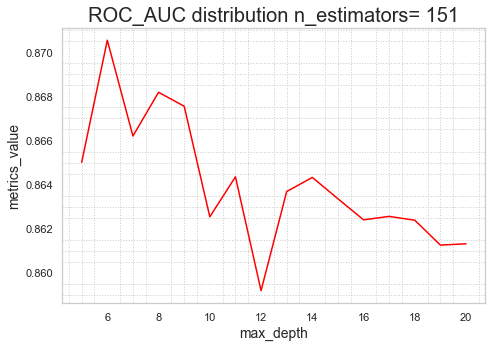

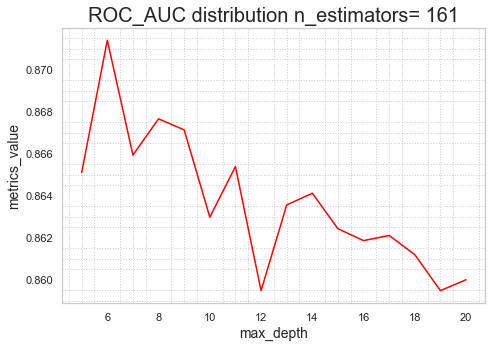

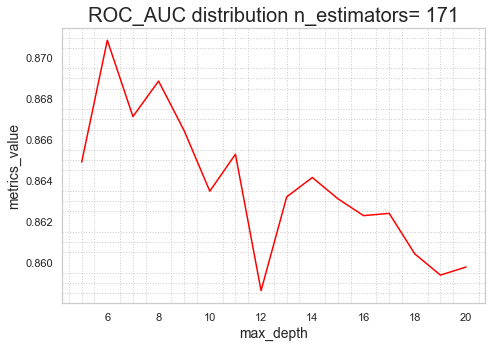

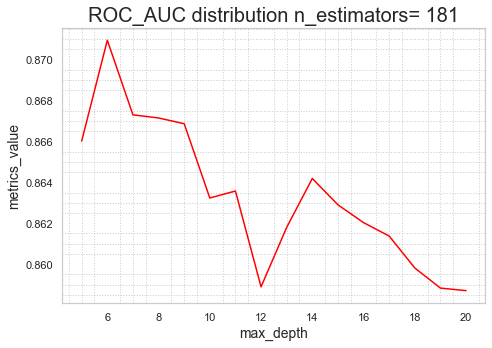

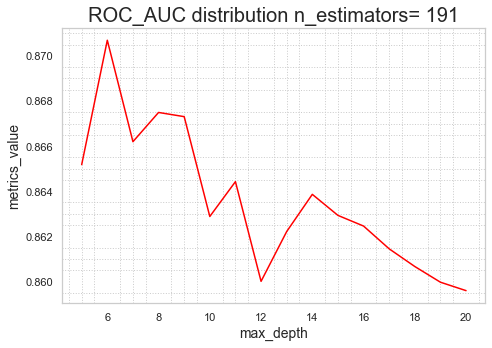

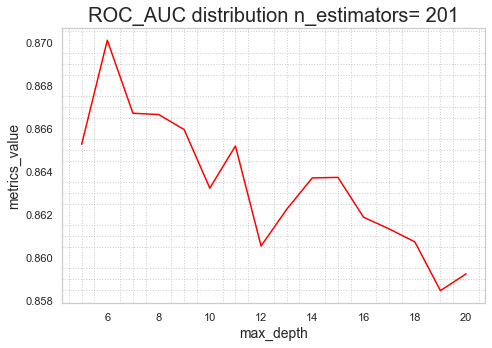

In [74]:
for i in grid_list_RFC_1[1]['param_n_estimators'].unique():
    x=grid_list_RFC_1[1][grid_list_RFC_1[1]['param_n_estimators'] == i]['param_max_depth']
    y=grid_list_RFC_1[1][grid_list_RFC_1[1]['param_n_estimators'] == i]['mean_test_score']
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, color='red', label='ROC_AUC')
    plt.xlabel('max_depth', fontsize=14)
    plt.ylabel('metrics_value', fontsize=14)
    plt.title('ROC_AUC distribution n_estimators= '+str(i), fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')
    plt.tight_layout()

    plt.show()

Запишем лучшую модель:

In [46]:
best_RFC_1 = RandomForestClassifier(
    n_estimators=grid_list_RFC_1[0].best_params_['n_estimators'],
    max_depth=grid_list_RFC_1[0].best_params_['max_depth'], random_state=42
)

Исследуем аналогичную модель, но с балансом классов:

In [47]:
%%time
# обучим модель случайного леса и подберем гиперпараметры
model_RFC_2 = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_RFC_2 = {'n_estimators': range(1,202,10),
                    'max_depth': range(5,21,1)
                   }
grid_list_RFC_2 = grid(model_RFC_2, param_grid_RFC_2)


Наилучшее значение ROC_AUC:
0.8692001509149216
Достигается при гиперпараметрах:
{'max_depth': 6, 'n_estimators': 121}
Wall time: 3min 27s


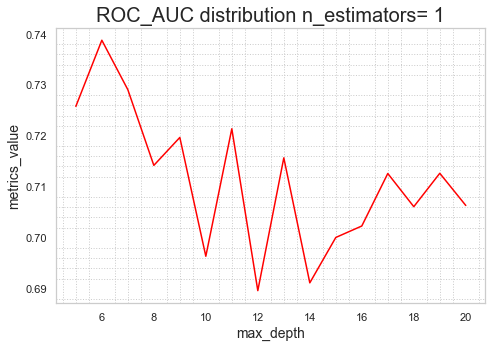

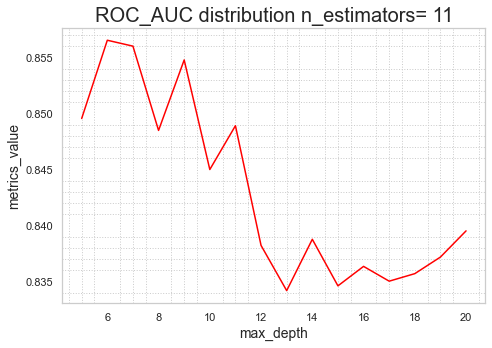

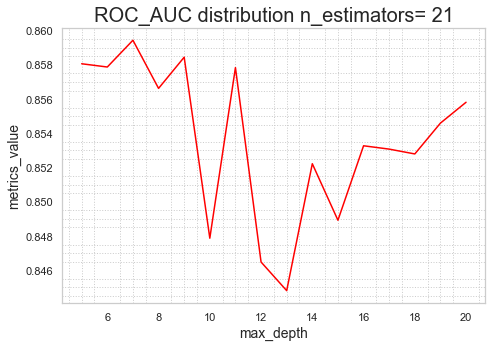

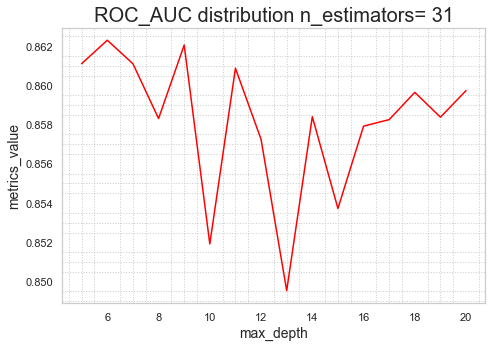

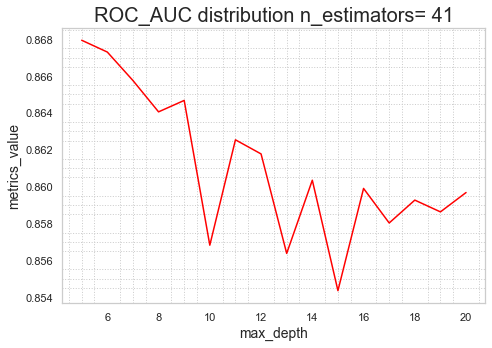

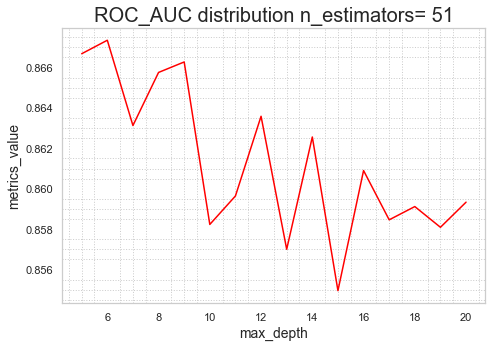

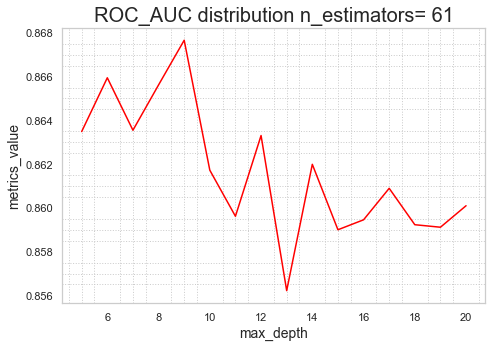

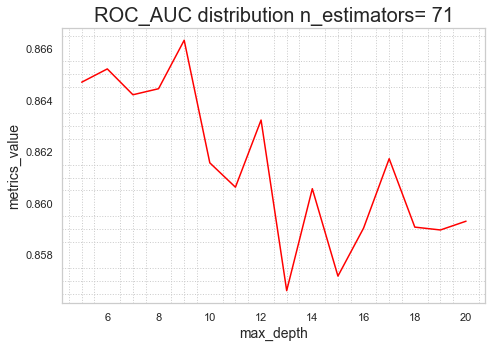

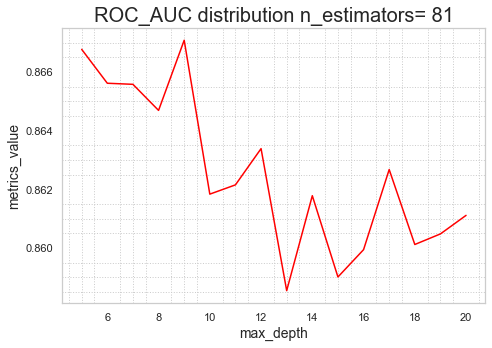

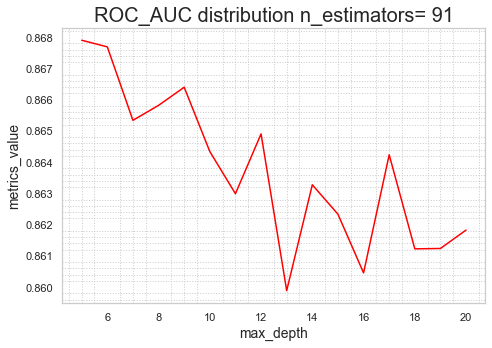

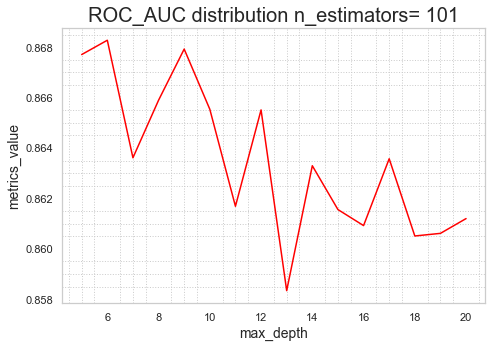

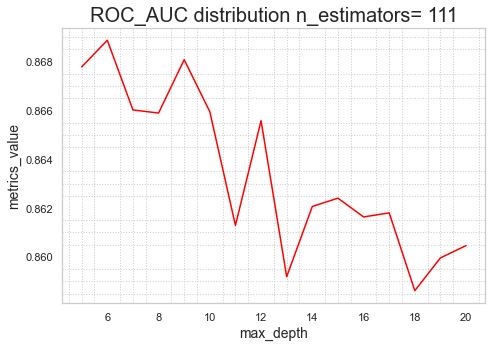

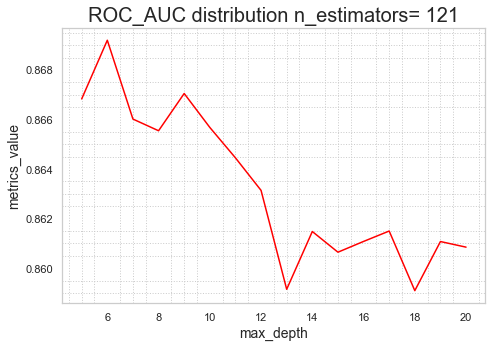

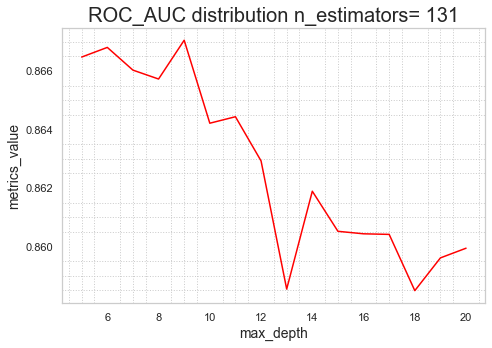

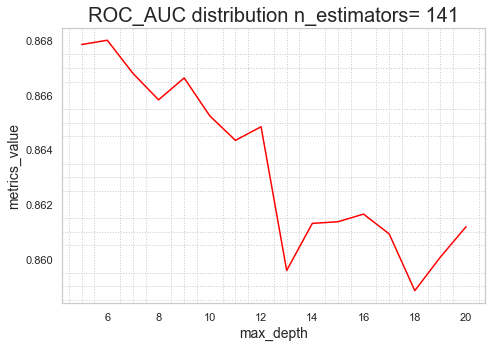

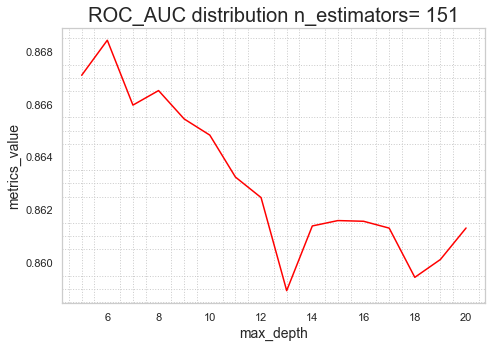

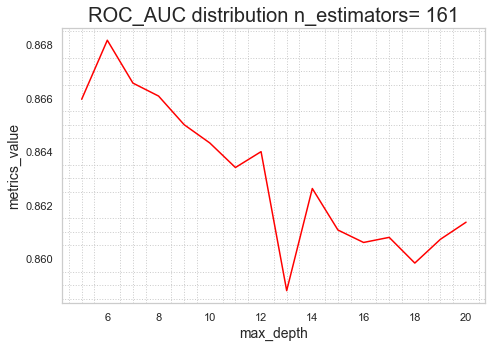

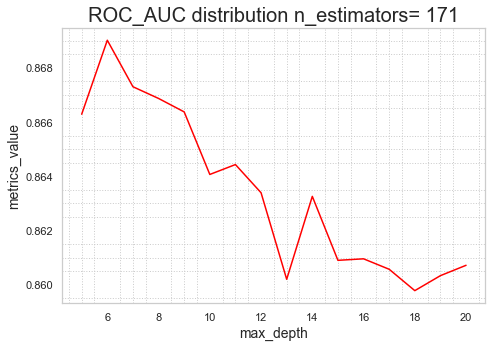

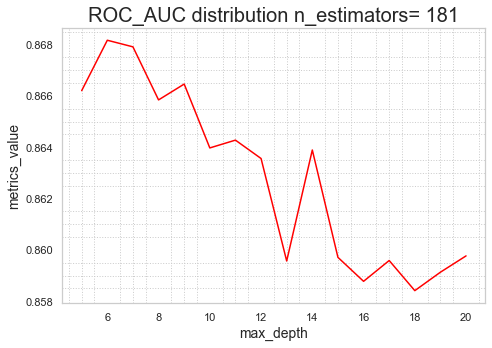

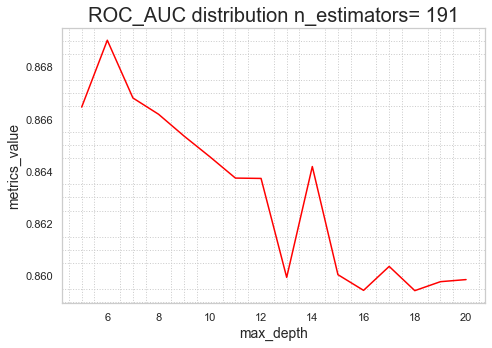

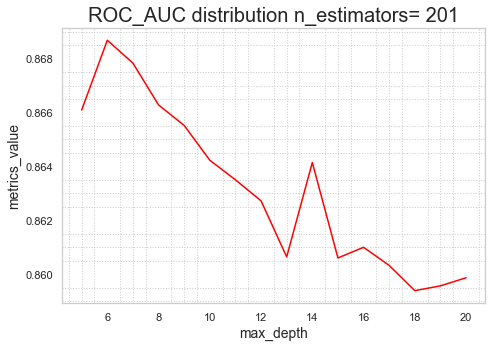

In [48]:
for i in grid_list_RFC_2[1]['param_n_estimators'].unique():
    x=grid_list_RFC_2[1][grid_list_RFC_2[1]['param_n_estimators'] == i]['param_max_depth']
    y=grid_list_RFC_2[1][grid_list_RFC_2[1]['param_n_estimators'] == i]['mean_test_score']
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, color='red', label='ROC_AUC')
    plt.xlabel('max_depth', fontsize=14)
    plt.ylabel('metrics_value', fontsize=14)
    plt.title('ROC_AUC distribution n_estimators= '+str(i), fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')
    plt.tight_layout()

    plt.show()

In [49]:
best_RFC_2 = RandomForestClassifier(
    n_estimators=grid_list_RFC_2[0].best_params_['n_estimators'],
    max_depth=grid_list_RFC_2[0].best_params_['max_depth'], random_state=42, class_weight='balanced'
)

#### 3.1.3 Логистическая регрессия

In [50]:
%%time
# обучим модель логистической регресии и подберем гиперпараметры
model_LR_1 = LogisticRegression(random_state=42)
param_grid_LR_1 = {'C': range(1,16),
                 'max_iter': range(250,501,50)}
grid_list_LR_1 = grid(model_LR_1, param_grid_LR_1)

Наилучшее значение ROC_AUC:
0.8642658859721678
Достигается при гиперпараметрах:
{'C': 4, 'max_iter': 250}
Wall time: 4.31 s


График распределения метрики в зависимости от гиперпараметров:

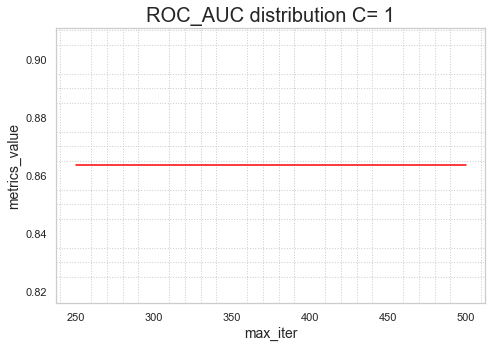

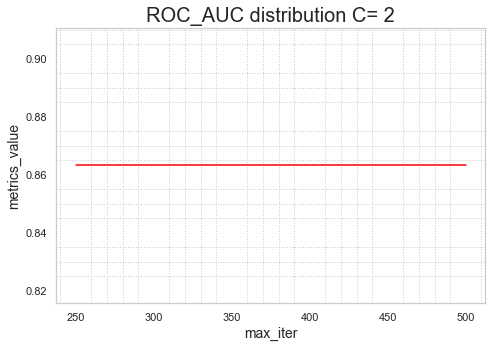

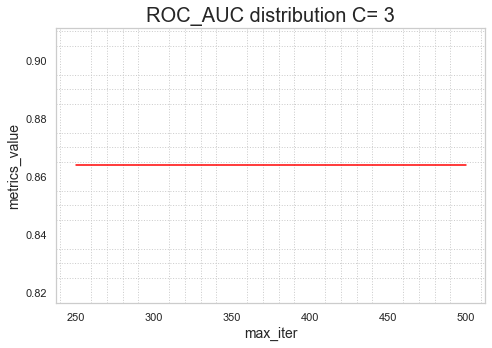

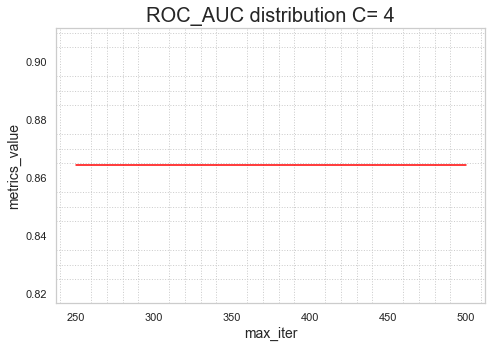

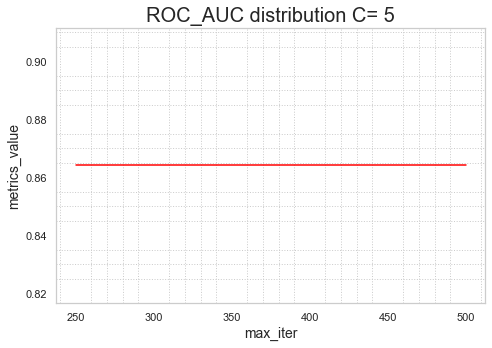

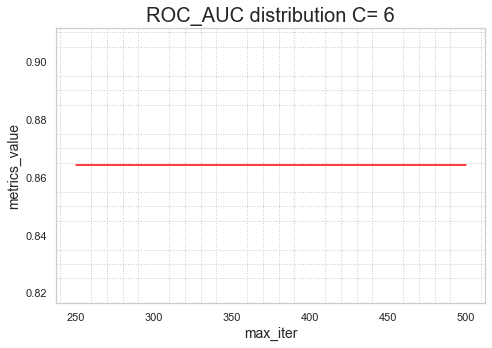

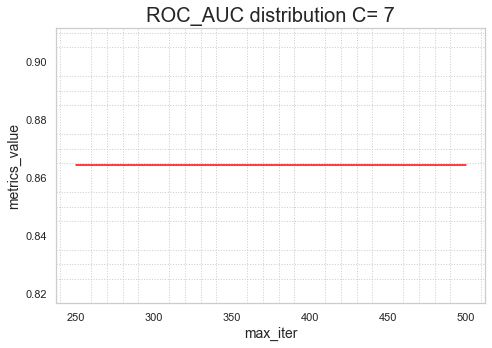

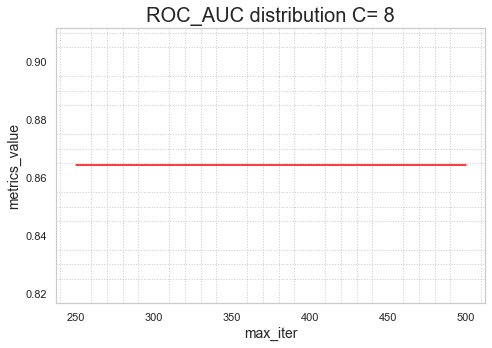

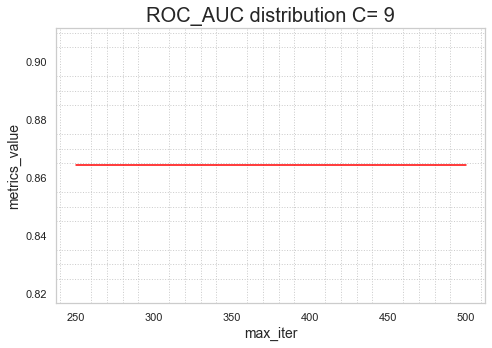

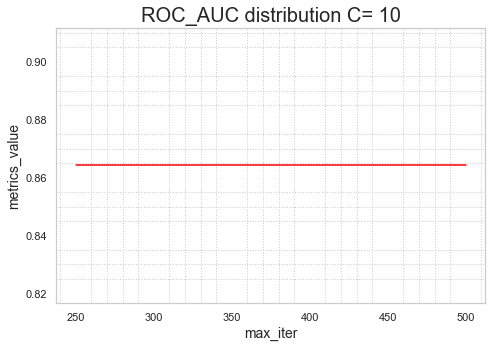

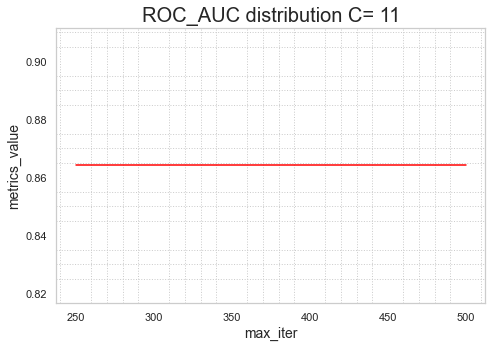

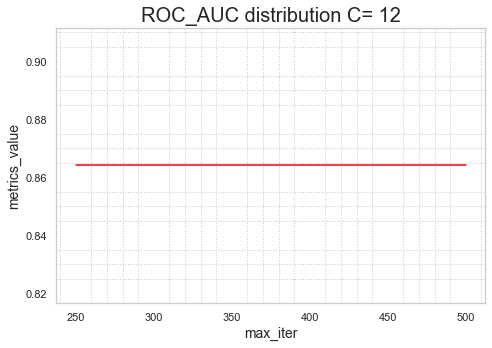

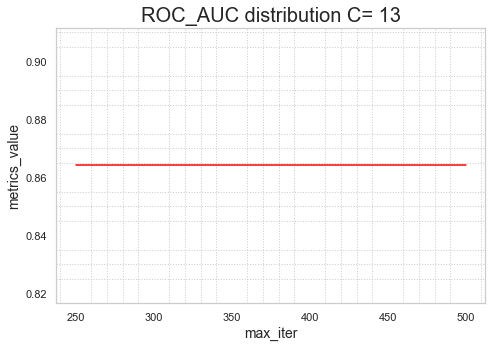

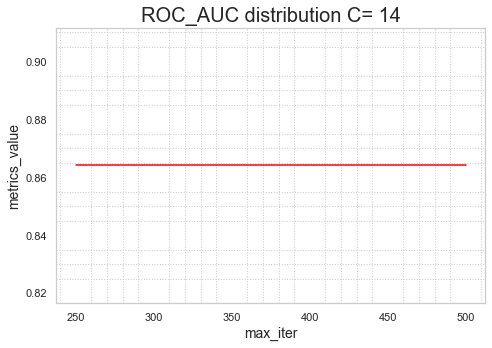

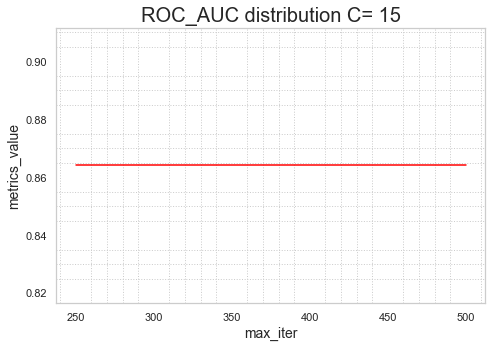

In [51]:
for i in grid_list_LR_1[1]['param_C'].unique():
    x=grid_list_LR_1[1][grid_list_LR_1[1]['param_C'] == i]['param_max_iter']
    y=grid_list_LR_1[1][grid_list_LR_1[1]['param_C'] == i]['mean_test_score']
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, color='red', label='ROC_AUC')
    plt.xlabel('max_iter', fontsize=14)
    plt.ylabel('metrics_value', fontsize=14)
    plt.title('ROC_AUC distribution C= '+str(i), fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')
    plt.tight_layout()

    plt.show()

Запишем лучшую модель:

In [52]:
best_LR_1 = LogisticRegression(
    C=grid_list_LR_1[0].best_params_['C'],
    random_state=42, max_iter=250
)

И с балансом классов:

In [53]:
%%time
# обучим модель логистической регресии и подберем гиперпараметры
model_LR_2 = LogisticRegression(random_state=42, class_weight='balanced')
param_grid_LR_2 = {'C': range(1,16),
                 'max_iter': range(250,501,50)}
grid_list_LR_2 = grid(model_LR_2, param_grid_LR_2)

Наилучшее значение ROC_AUC:
0.8639964883258602
Достигается при гиперпараметрах:
{'C': 1, 'max_iter': 250}
Wall time: 4.34 s


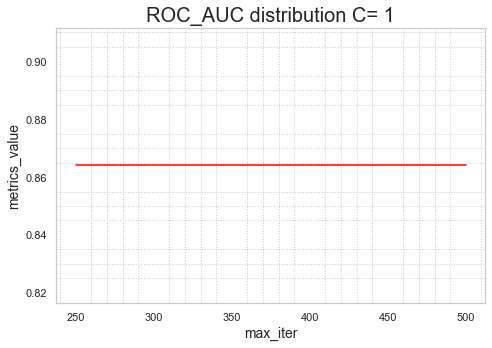

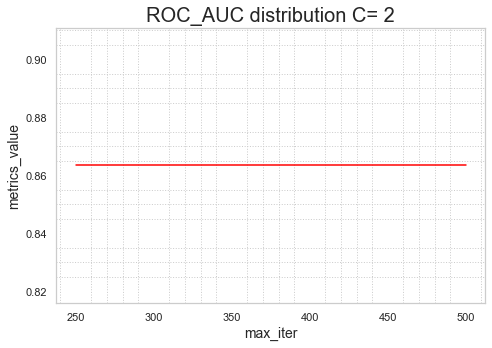

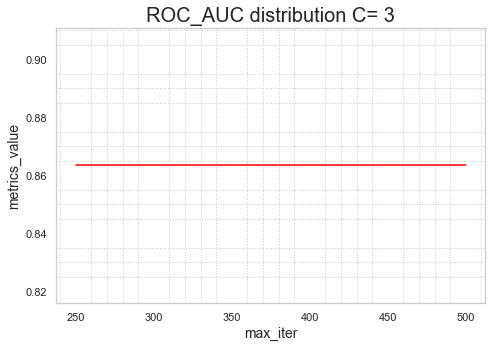

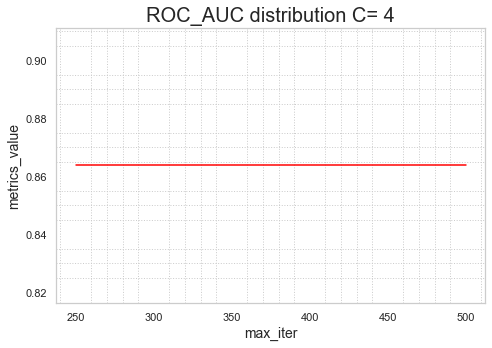

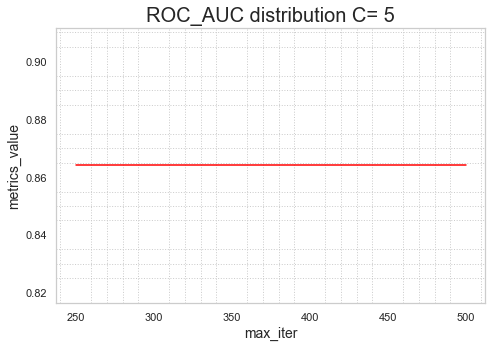

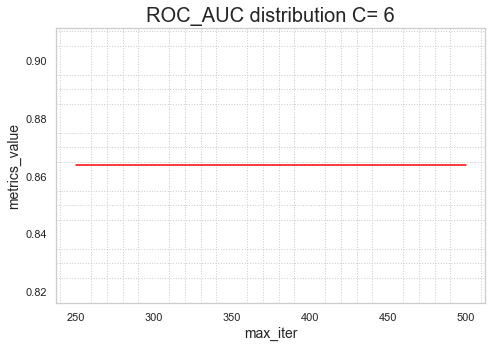

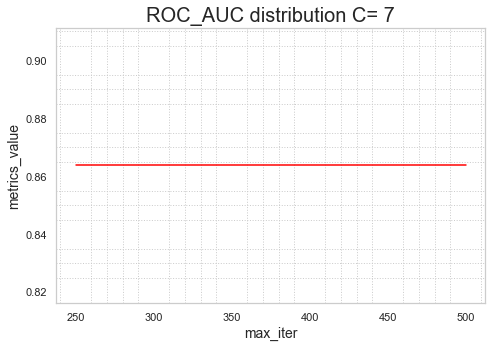

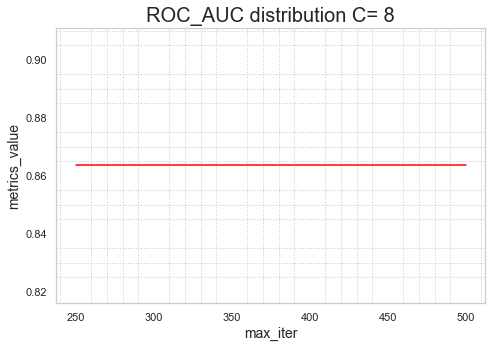

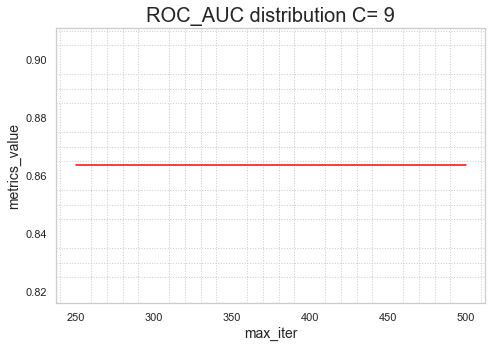

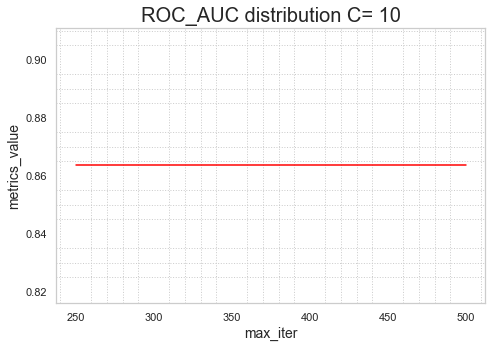

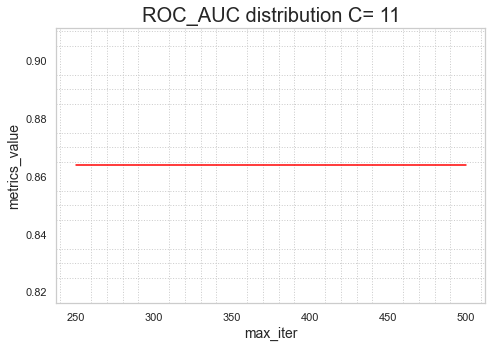

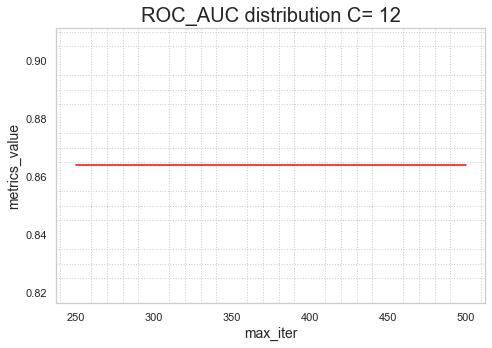

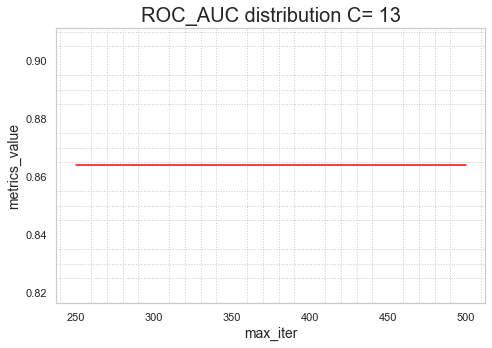

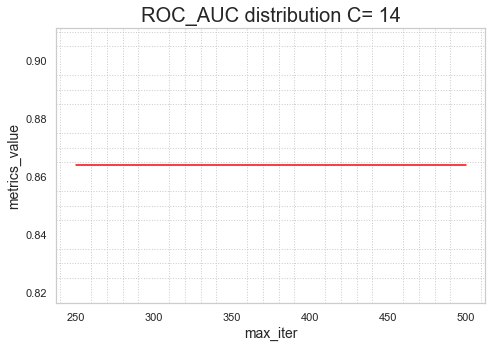

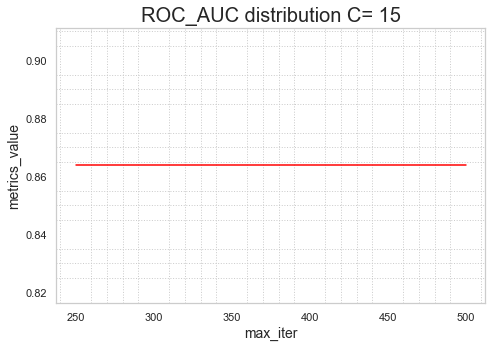

In [54]:
for i in grid_list_LR_2[1]['param_C'].unique():
    x=grid_list_LR_2[1][grid_list_LR_2[1]['param_C'] == i]['param_max_iter']
    y=grid_list_LR_2[1][grid_list_LR_2[1]['param_C'] == i]['mean_test_score']
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, color='red', label='ROC_AUC')
    plt.xlabel('max_iter', fontsize=14)
    plt.ylabel('metrics_value', fontsize=14)
    plt.title('ROC_AUC distribution C= '+str(i), fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')
    plt.tight_layout()

    plt.show()

In [55]:
best_LR_2 = LogisticRegression(
    C=grid_list_LR_2[0].best_params_['C'],
    random_state=42, max_iter=250, class_weight='balanced'
)

### 3.2 Выбор лучшей модели и проверка на тестовой выборке

Полученные результаты сведем в таблицу:

In [56]:
models_dict = {
                'balanced_class':['no','yes'],
                'DecisionTree_model':[grid_list_DTC_1[0].best_score_, grid_list_DTC_2[0].best_score_],
                'RandomForest_model':[grid_list_RFC_1[0].best_score_, grid_list_RFC_2[0].best_score_],
                'LogisticRegression_model':[grid_list_LR_1[0].best_score_, grid_list_LR_2[0].best_score_]
}
pd.DataFrame(data=models_dict, index=['ROC_AUC_1', 'ROC_AUC_2'])

balanced_class  DecisionTree_model  RandomForest_model  \
ROC_AUC_1             no            0.814348            0.871396   
ROC_AUC_2            yes            0.811496            0.869200   

           LogisticRegression_model  
ROC_AUC_1                  0.864266  
ROC_AUC_2                  0.863996

По полученным данным выигрывает первая модель случайного леса. Проверим качество по всем метрикам на тестовой выборке:

In [57]:
%%time
best_RFC_1.fit(features_train, target_train)
print(classification_report(target_test, best_RFC_1.predict(features_test)))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       103
           1       0.81      0.89      0.85       127

    accuracy                           0.82       230
   macro avg       0.83      0.81      0.82       230
weighted avg       0.82      0.82      0.82       230

Wall time: 237 ms


Матрица ошибок:

[[ 76  27]
 [ 14 113]]


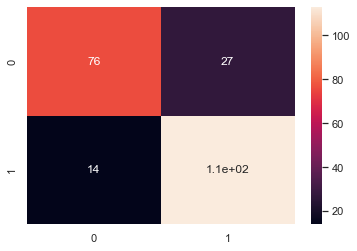

In [59]:
print(confusion_matrix(target_test,best_RFC_1.predict(features_test)))
sns.heatmap(confusion_matrix(target_test,best_RFC_1.predict(features_test)), annot=True);

ROC - кривая:

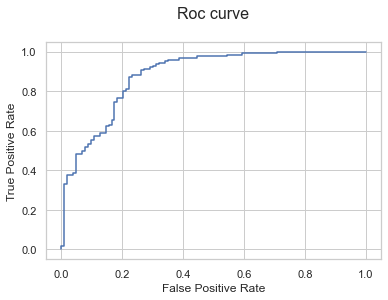

In [60]:
fpr, tpr, thresholds = roc_curve(target_test,best_RFC_1.predict_proba(features_test)[:,1])
plt.plot(fpr, tpr)
plt.title('Roc curve'+'\n', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');


Площадь под кривой ROC - ROC_AUC:

In [61]:
print('ROC_AUC:')
print(roc_auc_score(target_test, best_RFC_1.predict_proba(features_test)[:,1]))

ROC_AUC:
0.8815839767601866


Наиболее значимые признаки:

In [62]:
features.columns

Index(['age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca',
       'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina',
       'restecg_normal', 'restecg_st-t abnormality'],
      dtype='object')

In [66]:
features_name = ['Возраст',
                 'Артериальное давление',
                 'Уровень холестерина',
                 'Уровень сахара',
                 'Макс. частота серд. сокращений',
                'Стенокардия при физ. нагрузке',
                'Уменьшение ST',
                 'Количество крупных сосудов',
                'Пол',
                'Тип боли - атипичная стенокардия',
                'Тип боли - не стенокардия',
                 'Тип боли - типичная стенокардия',
                'Электрокардиограмма - в норме',
                'Электрокардиограмма - есть аномалия'
                
                ]

In [67]:
pd.Series(best_RFC_1.feature_importances_, index=features.columns)

age                         0.108318
trestbps                    0.056886
chol                        0.078716
fbs                         0.009591
thalch                      0.167804
exang                       0.000000
oldpeak                     0.175252
ca                          0.092528
sex_Male                    0.063284
cp_atypical angina          0.149623
cp_non-anginal              0.054433
cp_typical angina           0.015473
restecg_normal              0.018311
restecg_st-t abnormality    0.009781
dtype: float64

In [69]:
important_features = pd.Series(best_RFC_1.feature_importances_, index=features_name).reset_index()
important_features.index = important_features['index']
important_features.rename(columns={0:'features'}, inplace=True)


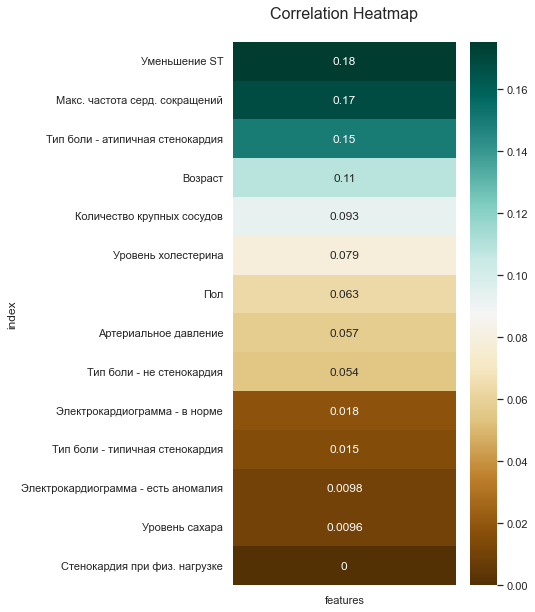

In [70]:
plt.figure(figsize=(5,10))
sns.heatmap(
    important_features[['features']].sort_values(
        by='features', ascending=False
    ), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap'+'\n', fontsize = 16);



## 4. Общий вывод

Задачей настоящего проекта является разработка модели машинного обучения для определения наличия сердечной болезни у пациента.


В качестве исходных данных получен датасет с информации о 920 различных пациентах, их анализах и праметрах, а так же с информацией о наличии той или иной стадии сердечного заболевания или их отсутсвия.

Проведени исследовательский анализ данных в результате которого выяснил:
* Есть пропущенные значени признаков, которые можно заменить на среднее или медиану. Метод describe показал;
* Есть значения уровня холестирина и артериального давления равные нулю, что так же необходимо поправить;
* Данные колонок с уникальным номером, а так же с местом сбора данных не информативны для построения модели - их можно удалить;
* Выявлена некоторая зависимость стадии заболевания от возраста, артериального давления.

Проведена прелобработка данных:
* Заменены пропуски;
* Удалены дубликаты;
* Стандартизированы данные.

Обучены и подбраны наилучшие гиперпараметры трех моделей:
* Дерево решений;
* Случайный лес;
* Логистическая регрессия.

Наилучшие результаты на тестовой выборке показала модель случайного леса:
* ROC_AUC - 0,88 - удовлетворительное значение;
* recall - 0,89 - а это значит, что ложноотрицательных ответов будет мало, что нам и нужно - пациенту, у которого есть бользнь модель в редких случаях поставит, что нет. В большинстве случаев модель правильно угадывает как раз пациентов с болезнью для назначения дальнейшего обследования;
* Основные признаки влияющие на приятие решения моделью предсавлны на графике выше.
